# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

customers, features = azdias.shape
print(azdias.shape)
print(f"Number of customers is {customers}, each customer has {features} features.")
all_null = azdias.isnull().sum().sum()
not_null = azdias.notnull().sum().sum()
print(f"Null values number for all table is {all_null}, while not null values count is {not_null}") 

(891221, 85)
Number of customers is 891221, each customer has 85 features.
Null values number for all table is 4896838, while not null values count is 70856947


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
def prepare_mess(df):
    for attribute, miss_index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_values = miss_index.strip('[]').split(',')
        missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
        if missing_values != ['']:
            df[attribute] = df[attribute].replace(missing_values, np.nan)

In [9]:
prepare_mess(azdias)

In [10]:
all_null = azdias.isnull().sum().sum()
not_null = azdias.notnull().sum().sum()
print(f"Null values number for all table is {all_null}, while not null values count is {not_null}") 

Null values number for all table is 8373929, while not null values count is 67379856


In [11]:
each_col_null = azdias.isnull().sum().sort_values(ascending=False)
each_col_null

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
                 ...  
SEMIO_RAT            0
SEMIO_KRIT           0
SEMIO_DOM            0
SEMIO_TRADV          0
ZABEOTYP             0
Length: 85, dtype: int64

In [12]:
def get_not_null_cols(df):
    count=0
    for i in df.columns:
        c = df[i].isnull().values.any() == 0
        if c == True:
            count+=1
            print(i)
    print(f"\n\nNumber of columns that hasn't null values: {count}")

    
get_not_null_cols(azdias)

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


Number of columns that hasn't null values: 24


In [13]:
def get_null_cols(df):
    count=0
    #sum=0
    for i in df.columns:
        num_null = df[i].isnull().sum()
        c = df[i].isnull().values.any() != 0
        if c == True:
            count+=1
            #print(i, ' '*25, num_null)
            print("{0:30} {1:10}".format(i, num_null))
            #sum += num_null
    print(f"\n\nNumber of columns that has null values: {count}")

    

get_null_cols(azdias)

AGER_TYP                           685843
ALTERSKATEGORIE_GROB                 2881
CJT_GESAMTTYP                        4854
GEBURTSJAHR                        392318
GFK_URLAUBERTYP                      4854
HEALTH_TYP                         111196
LP_LEBENSPHASE_FEIN                 97632
LP_LEBENSPHASE_GROB                 94572
LP_FAMILIE_FEIN                     77792
LP_FAMILIE_GROB                     77792
LP_STATUS_FEIN                       4854
LP_STATUS_GROB                       4854
NATIONALITAET_KZ                   108315
PRAEGENDE_JUGENDJAHRE              108164
RETOURTYP_BK_S                       4854
SHOPPER_TYP                        111196
SOHO_KZ                             73499
TITEL_KZ                           889061
VERS_TYP                           111196
ALTER_HH                           310267
ANZ_PERSONEN                        73499
ANZ_TITEL                           73499
HH_EINKOMMEN_SCORE                  18348
KK_KUNDENTYP                      

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
def plotHist(df1, df2, title, name1, name2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    axes[0].hist(df1, bins=100)
    axes[1].hist(df2, bins=100)
    
    axes[0].set_title(name1)
    axes[1].set_title(name2)
    plt.show()


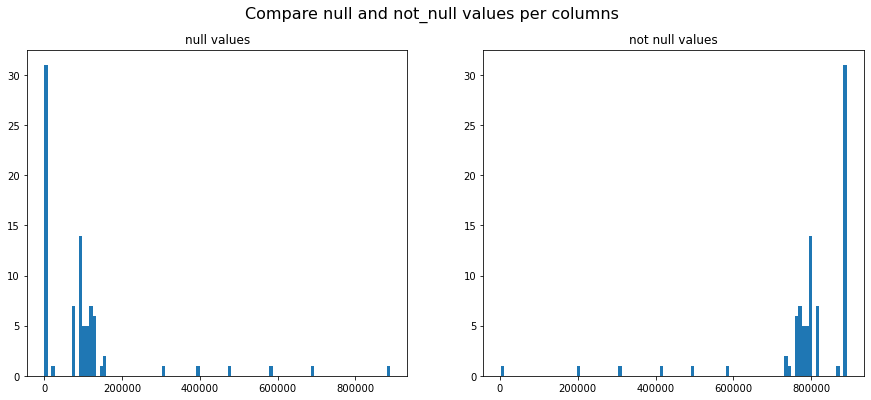

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Plot the histogram with hist() function

plotHist(azdias.isnull().sum(), azdias.notnull().sum(), 
         "Compare null and not_null values per columns", "null values",
         "not null values")

In [16]:
# Investigate patterns in the amount of missing data in each column.

def get_null_cols(df):
    count=0
    print("{0:30} {1:10}".format('Column Name', 'Number of missing cells'))
    print('-'*50)
    for i in df.columns:
        num_null = df[i].isnull().sum()
        c = df[i].isnull().values.any() != 0
        if c == True:
            count+=1
            print("{0:30} {1:10}".format(i, num_null))
    print(f"\n\nNumber of columns that has null values: {count}")

    
    
    
get_null_cols(azdias)

Column Name                    Number of missing cells
--------------------------------------------------
AGER_TYP                           685843
ALTERSKATEGORIE_GROB                 2881
CJT_GESAMTTYP                        4854
GEBURTSJAHR                        392318
GFK_URLAUBERTYP                      4854
HEALTH_TYP                         111196
LP_LEBENSPHASE_FEIN                 97632
LP_LEBENSPHASE_GROB                 94572
LP_FAMILIE_FEIN                     77792
LP_FAMILIE_GROB                     77792
LP_STATUS_FEIN                       4854
LP_STATUS_GROB                       4854
NATIONALITAET_KZ                   108315
PRAEGENDE_JUGENDJAHRE              108164
RETOURTYP_BK_S                       4854
SHOPPER_TYP                        111196
SOHO_KZ                             73499
TITEL_KZ                           889061
VERS_TYP                           111196
ALTER_HH                           310267
ANZ_PERSONEN                        73499
ANZ_TITEL   

In [17]:
# drop columns with null values <200000
def remove_null_outliers(df):
    count=0
    drop_outliers = []
    
    print("{0:30} {1:10}".format('Column Name', 'Number of missing cells'))
    print('-'*50)
    for i in df.columns:
        num_null = df[i].isnull().sum()
        c = num_null > 200000 
        if c == True:
            drop_outliers.append(i)
            count+=1
            print("{0:30} {1:10}".format(i, num_null))
    print(f"\n\nNumber of columns that has null values > 200000: {count}")
    return drop_outliers


drop_outliers = remove_null_outliers(azdias)

Column Name                    Number of missing cells
--------------------------------------------------
AGER_TYP                           685843
GEBURTSJAHR                        392318
TITEL_KZ                           889061
ALTER_HH                           310267
KK_KUNDENTYP                       584612
KBA05_BAUMAX                       476524


Number of columns that has null values > 200000: 6
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
6


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


azdias.drop(drop_outliers, axis=1, inplace=True)
#azdias.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0


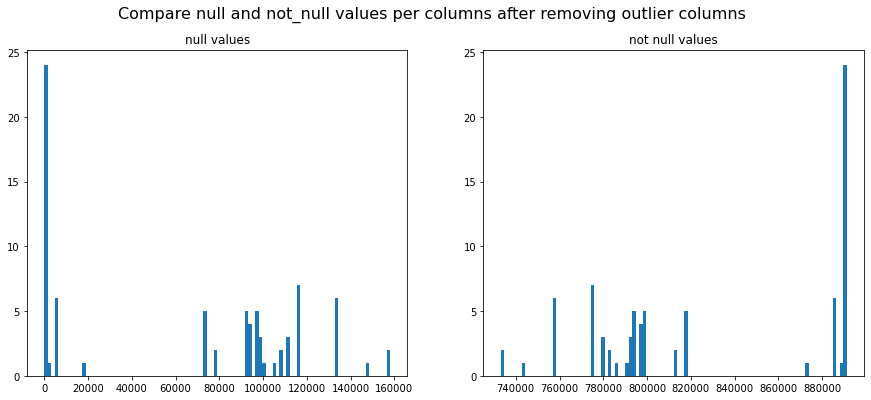

In [19]:
plotHist(azdias.isnull().sum(), azdias.notnull().sum(), 
         "Compare null and not_null values per columns after removing outlier columns", "null values",
         "not null values")

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer**
- there 6 columns that ate removed from dataset as they contain null values above 200000 cells which is approxiately quarter the number of information filled in the column (891221 cell), these columns are:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
- Also in the outliers there are columns (24 columns) that are completely filled with information (null values=0), which are need to keep as they are the most important part of data due to its completeness.
- Most of columns with null values contains below 200000
- the distribution becomes nearer to normal distribution as in the plot above than that before removing outlier columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

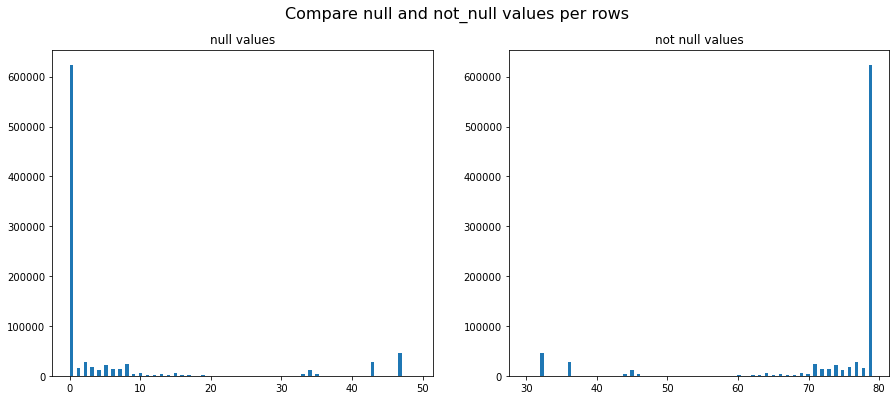

In [20]:
plotHist(azdias.isnull().sum(axis=1), azdias.notnull().sum(axis=1), 
         "Compare null and not_null values per rows", "null values",
         "not null values")

In [21]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
non_null_rows = azdias[azdias.isnull().sum(axis=1)==0]
#print(non_null_rows)
print(f'\nNumber of rows that hasn\'t any missing values: {len(non_null_rows)}', end='\n\n')
print('*'*42)

above_25_null = azdias[azdias.isnull().sum(axis=1)>25]
#print(above_25_null)
print(f'\nNumber of rows that has missing values number above 25: {len(above_25_null)}', end='\n\n')
print('*'*42)

below_25_null = azdias[azdias.isnull().sum(axis=1)<=25]
#print(below_25_null)
print(f'\nNumber of rows that has missing values number below 25: {len(below_25_null)}', end='\n\n')


Number of rows that hasn't any missing values: 623209

******************************************

Number of rows that has missing values number above 25: 93260

******************************************

Number of rows that has missing values number below 25: 797961



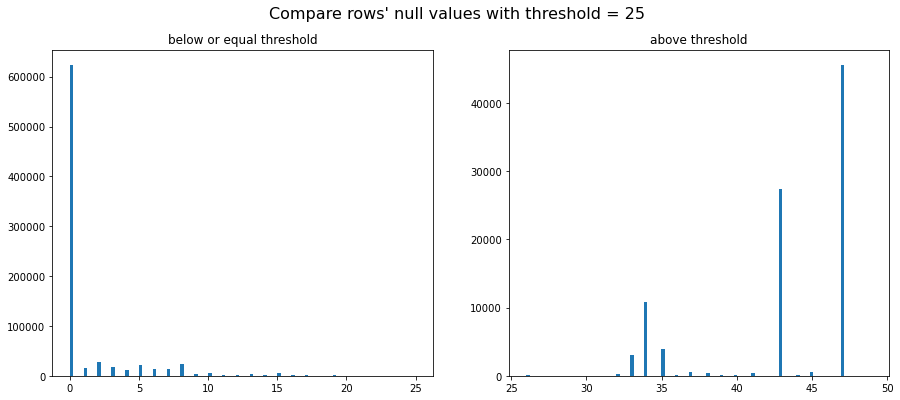

In [23]:
plotHist(below_25_null.isnull().sum(axis=1), 
         above_25_null.isnull().sum(axis=1),
         "Compare rows' null values with threshold = 25",
         "below or equal threshold", "above threshold")

In [24]:
above_25_cols = above_25_null.isnull().sum()[above_25_null.isnull().sum()==0]
below_25_cols = below_25_null.isnull().sum()[below_25_null.isnull().sum()==0]

        
print(above_25_cols)
print(f'Number of completely filled columns for rows with null values above 25: {len(above_25_cols)}', end='\n\n')
print('*'*80, end='\n\n')
print(below_25_cols)
print(f'Number of completely filled columns for rows with null values below 25: {len(below_25_cols)}', end='\n\n')

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64
Number of completely filled columns for rows with null values above 25: 24

********************************************************************************

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER   

In [25]:
above_25_null = azdias.drop(azdias[azdias.isnull().sum(axis=1)<=25].index)
below_25_null = azdias.drop(azdias[azdias.isnull().sum(axis=1)>25].index)

In [26]:
above_25_cols_lst = [i for i in above_25_cols.index]
below_25_cols_lst = [i for i in below_25_cols.index]

match_similar_cols = [x for x in above_25_cols_lst for y in below_25_cols_lst if x==y]


print(f'Number of completely filled columns for rows with null values above 25:\n')
print(above_25_cols_lst)
print(len(above_25_cols_lst))
print('\n\n', end='*'*100)

print(f'\nNumber of completely filled columns for rows with null values below 25:\n')
print(below_25_cols_lst)
print(len(below_25_cols_lst))
print('\n\n', end='*'*100)

print(f'\nMatching similar completely filled columns for rows with null values below and above 25:\n')
print(match_similar_cols)
print(len(match_similar_cols))

Number of completely filled columns for rows with null values above 25:

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
24


****************************************************************************************************
Number of completely filled columns for rows with null values below 25:

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ZA

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


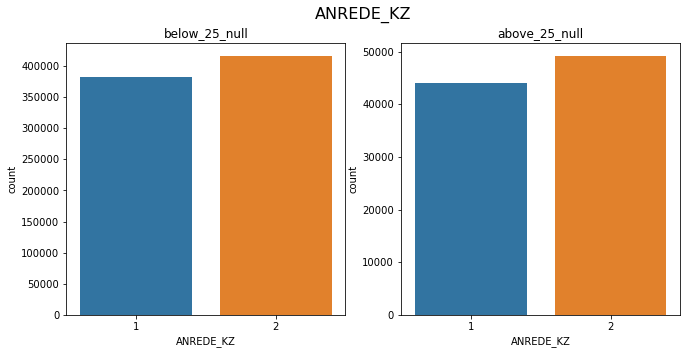

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


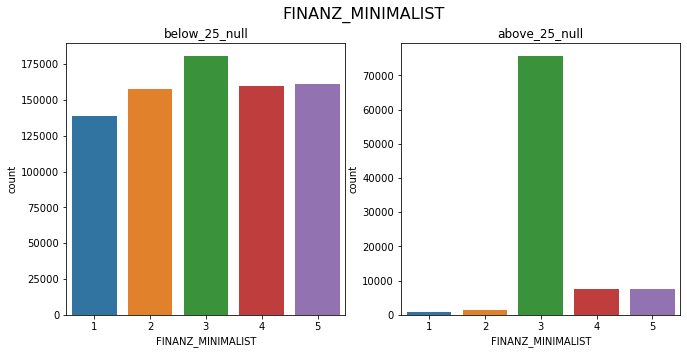

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


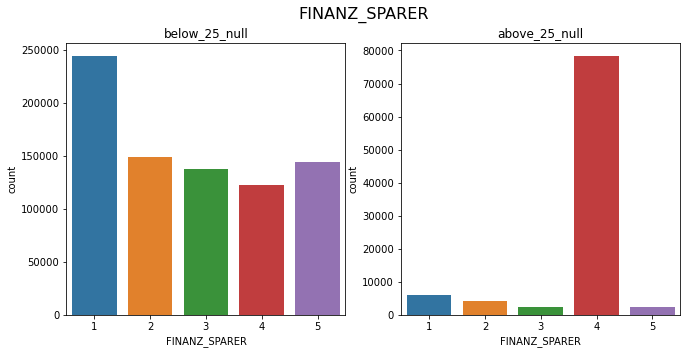

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


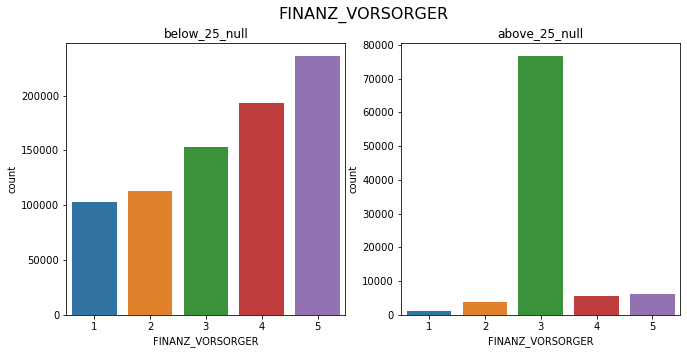

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


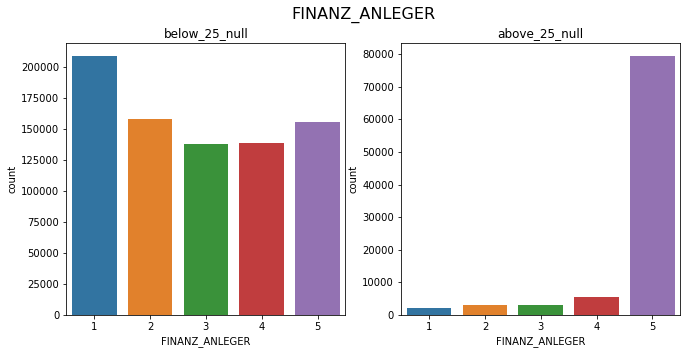

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


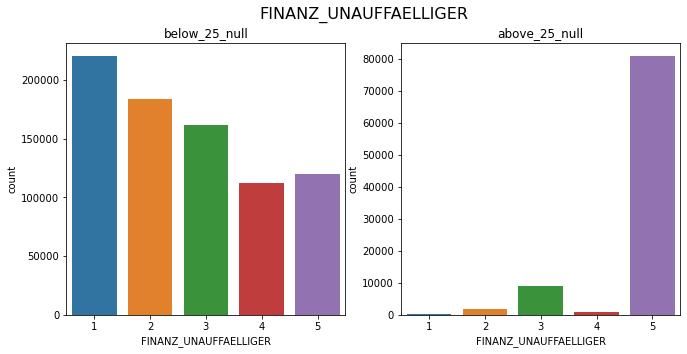

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


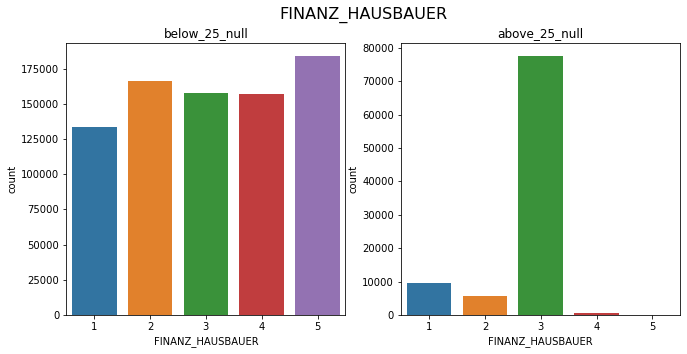

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


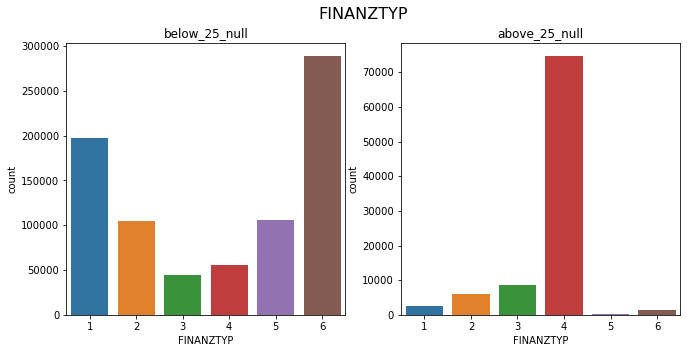

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


# plot using countplot()
def plotData(df1, df2, colNames_lst, name1, name2):
    for i in colNames_lst:
        fig, axes = plt.subplots(1, 2, figsize=(11, 5))
        fig.suptitle(i, fontsize=16)
        
        sns.countplot(df1[i], ax=axes[0])
        sns.countplot(df2[i], ax=axes[1])
        
        axes[0].set_title(name1)
        axes[1].set_title(name2)
        plt.show()
        
        

plotData(below_25_null, above_25_null, match_similar_cols[:8], 'below_25_null', 'above_25_null')

In [28]:
match_similar_cols[:8]     # plotted rows comparison according to these columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP']

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Answer**
- After plotting missing values in columns for splitted data rows, I just used 8 columns to compare, the null values below the used threshold (25) are completely different from those that are avove the threshold.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
string_columns = azdias.dtypes[azdias.dtypes == object].index
string_columns

Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')

In [30]:
print(feat_info['type'].value_counts())#.values)

type_counts = list(feat_info['type'].value_counts().index)
type_counts

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


['ordinal', 'categorical', 'numeric', 'mixed', 'interval']

In [31]:
# to get only 'categorical', 'mixed' values in type_counts list
type_counts_alter = [type_counts[1] , type_counts[3]]
type_counts_alter

['categorical', 'mixed']

In [32]:
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [33]:
def count_col_types(df1, col_search, col_match, values_lst):
    col_match_lst = []
    col_value_lst = []
    
    for idx1, i in enumerate(df1[col_search]):
        for idx2, j in enumerate(df1[col_match]):
            if idx1==idx2:
                if i in values_lst:
                    col_match_lst.append(j)
                    col_value_lst.append(i)

    name_val = dict(zip(col_match_lst, col_value_lst))
    
    all_lst = []
    all_lst_len = []
    
    for v in values_lst:
        each_value_lst = []
        
        for val in name_val:
            if name_val[val] == v:
                each_value_lst.append(val)
        all_lst.append(each_value_lst)
        all_lst_len.append(len(each_value_lst))
        
    dict_count_types = dict(zip(values_lst, all_lst_len))
    dict_type_cols = dict(zip(values_lst, all_lst))
    
    return name_val, all_lst, col_match_lst, dict_count_types, dict_type_cols
                    

    
name_val, all_lst, col_match_all_lst, dict_count_types, dict_type_cols = count_col_types(feat_info, 'type', 
                                                                                     'attribute', type_counts)


print("all types counts: ")
print(dict_count_types, end='\n\n\n')

print("each column category dictionary: ")
print(dict_type_cols, end='\n\n\n')

all types counts: 
{'ordinal': 49, 'categorical': 21, 'numeric': 7, 'mixed': 7, 'interval': 1}


each column category dictionary: 
{'ordinal': ['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB'], 'categorical': ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE'

In [34]:
name_val, all_lst, col_match_lst, dict_count_types, dict_type_cols = count_col_types(feat_info, 'type', 'attribute', 
                                                                                     type_counts_alter)

print(col_match_lst, end='\n\n\n')
print(dict_count_types, end='\n\n\n')
print(dict_type_cols)

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


{'categorical': 21, 'mixed': 7}


{'categorical': ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], 'mixed': ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']}


In [35]:
# to get only 'categorical' values in dataframe
name_val, all_lst, col_match_lst, dict_count_types, dict_type_cols = count_col_types(feat_info, 'type', 'attribute', 
                                                                                     ['categorical'])
#col_match_lst carries 'categorical'
categorical =  pd.DataFrame(azdias, columns=col_match_lst)

AGER_TYP            float64
ANREDE_KZ             int64
CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE      int64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
TITEL_KZ            float64
VERS_TYP            float64
ZABEOTYP              int64
KK_KUNDENTYP        float64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [603]:
name_val, all_lst, col_match_lst, dict_count_types, dict_type_cols = count_col_types(feat_info, 'type', 'attribute', 
                                                                                ['categorical'])

In [37]:
# How many features are there of each data type? 

# note that I have removed 6 columns from azdias before this step, so azdias now 79 columns which are:
# ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


def show_col_classes(df_sumry, df_full, type_lst, col_search, col_match):
    all_features_lst = []
    
    for i in type_lst:
        print('{0:20} {1:25}'.format('column name', f'number of unique features for {i}'))
        print('-'*60)
        
        feature_lst = []
        c=0
        for a in df_sumry[col_match][df_sumry[col_search]==i]:
            if a in df_full.columns:
                feature_lst.append(a)
                c+=1
                print('{0:25} {1:15}'.format(a, df_full[a].nunique()))
        
        all_features_lst.append(feature_lst)
        if len(all_features_lst)==1:
            all_features_lst = [i for lst in all_features_lst for i in lst]
            
        print(f'\nNumber of columns related to {i}: {c}')
        print('\n\n\n', '-'*60)    
    
    return all_features_lst

        
all_features_lst = show_col_classes(feat_info, azdias, type_counts, 'type', 'attribute')

column name          number of unique features for ordinal
------------------------------------------------------------
ALTERSKATEGORIE_GROB                    4
FINANZ_MINIMALIST                       5
FINANZ_SPARER                           5
FINANZ_VORSORGER                        5
FINANZ_ANLEGER                          5
FINANZ_UNAUFFAELLIGER                   5
FINANZ_HAUSBAUER                        5
HEALTH_TYP                              3
RETOURTYP_BK_S                          5
SEMIO_SOZ                               7
SEMIO_FAM                               7
SEMIO_REL                               7
SEMIO_MAT                               7
SEMIO_VERT                              7
SEMIO_LUST                              7
SEMIO_ERL                               7
SEMIO_KULT                              7
SEMIO_RAT                               7
SEMIO_KRIT                              7
SEMIO_DOM                               7
SEMIO_KAEM                              

In [38]:
categorical_cols = show_col_classes(feat_info, azdias, ['categorical'], 'type', 'attribute')

column name          number of unique features for categorical
------------------------------------------------------------
ANREDE_KZ                               2
CJT_GESAMTTYP                           6
FINANZTYP                               6
GFK_URLAUBERTYP                        12
GREEN_AVANTGARDE                        2
LP_FAMILIE_FEIN                        11
LP_FAMILIE_GROB                         5
LP_STATUS_FEIN                         10
LP_STATUS_GROB                          5
NATIONALITAET_KZ                        3
SHOPPER_TYP                             4
SOHO_KZ                                 2
VERS_TYP                                2
ZABEOTYP                                6
GEBAEUDETYP                             7
OST_WEST_KZ                             2
CAMEO_DEUG_2015                         9
CAMEO_DEU_2015                         44

Number of columns related to categorical: 18



 ------------------------------------------------------------


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
from prettytable import PrettyTable

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def keep_remove(col_lst, df_full, region=10, val='what'):
    myTable = PrettyTable(["column name", f"Num. unique features for {val}", "unique values"])
    space = '-'*int(region)

    
    c2=0
    c6=0
    cr=0
    all_values=0
    
    for a in col_lst:
      
        if a in df_full.columns:
            if df_full[a].nunique() == 2:
                myTable.add_row([a, df_full[a].nunique(), df_full[a].unique()])
                c2+=1
                all_values+=df_full[a].nunique()
    
    
    myTable.add_row([space, space*2, space*3])
    
    
    for a in col_lst:
        if a in df_full.columns: 
            if df_full[a].nunique() > 6:
                myTable.add_row([a, df_full[a].nunique(), df_full[a].unique()])
                c6+=1
                all_values+=df_full[a].nunique()
                
    
    myTable.add_row([space, space*2, space*3])
 
    
    
    for a in col_lst:
        if a in df_full.columns: 
            if df_full[a].nunique() != 2 and not df_full[a].nunique() > 6:
                myTable.add_row([a, df_full[a].nunique(), df_full[a].unique()])
                cr+=1
                all_values+=df_full[a].nunique()
    
    
    print(myTable)
    print(f'\nNumber of binary columns: {c2}')
    print(f'\nNumber columns that has more than 6 features: {c6}')
    print(f'\nNumber of rest of columns: {cr}')
    print(f'\nNumber of all unique values: {all_values}')
    print(f'\nNumber of columns related to {val}: {len(col_lst)}')

In [41]:
keep_remove(categorical_cols, azdias, 18, 'categorical')

+--------------------+--------------------------------------+----------------------------------------------------------------------------+
|    column name     | Num. unique features for categorical |                               unique values                                |
+--------------------+--------------------------------------+----------------------------------------------------------------------------+
|     ANREDE_KZ      |                  2                   |                                   [1 2]                                    |
|  GREEN_AVANTGARDE  |                  2                   |                                   [0 1]                                    |
|      SOHO_KZ       |                  2                   |                               [nan  1.  0.]                                |
|      VERS_TYP      |                  2                   |                               [nan  2.  1.]                                |
|    OST_WEST_KZ     |     

In [42]:
azdias.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)
#azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [43]:
categorical_cols = show_col_classes(feat_info, azdias, ['categorical'], 'type', 'attribute')

column name          number of unique features for categorical
------------------------------------------------------------
ANREDE_KZ                               2
CJT_GESAMTTYP                           6
FINANZTYP                               6
GFK_URLAUBERTYP                        12
GREEN_AVANTGARDE                        2
LP_FAMILIE_FEIN                        11
LP_FAMILIE_GROB                         5
LP_STATUS_FEIN                         10
LP_STATUS_GROB                          5
NATIONALITAET_KZ                        3
SHOPPER_TYP                             4
SOHO_KZ                                 2
VERS_TYP                                2
ZABEOTYP                                6
GEBAEUDETYP                             7
OST_WEST_KZ                             2
CAMEO_DEUG_2015                         9

Number of columns related to categorical: 17



 ------------------------------------------------------------


In [44]:
keep_remove(categorical_cols, azdias, 18, 'categorical')

+--------------------+--------------------------------------+--------------------------------------------------------+
|    column name     | Num. unique features for categorical |                     unique values                      |
+--------------------+--------------------------------------+--------------------------------------------------------+
|     ANREDE_KZ      |                  2                   |                         [1 2]                          |
|  GREEN_AVANTGARDE  |                  2                   |                         [0 1]                          |
|      SOHO_KZ       |                  2                   |                     [nan  1.  0.]                      |
|      VERS_TYP      |                  2                   |                     [nan  2.  1.]                      |
|    OST_WEST_KZ     |                  2                   |                     [nan 'W' 'O']                      |
| ------------------ | -------------------------

In [45]:
azdias[categorical_cols].shape

(891221, 17)

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
categorical_encode = azdias[categorical_cols]
#categorical_encode.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015
0,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6


In [47]:
# remove this columns from azdias as we encoded them 
azdias.drop(categorical_cols, axis=1, inplace=True)
#azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,3,4,3,5,5,3,NaN,15.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [48]:
X = pd.DataFrame(enc.fit_transform(categorical_encode).toarray())
#print(type(X))
#X.head()

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [49]:
#X.columns
for i in range(len(X.columns)):
    X.rename(columns = {i:f'categorical_{i}'}, inplace = True)

#X.columns
#X.head()

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9,...,categorical_97,categorical_98,categorical_99,categorical_100,categorical_101,categorical_102,categorical_103,categorical_104,categorical_105,categorical_106
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


**Answer:**
- I noticed that columns:
-      'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ' have binary features per column.
-      'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015' has above 6 unique features per column.
-      'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP' are the rest of columns which has number of unique values in the range between 3 and 6.
- I decided to drop['CAMEO_DEU_2015'] as it has too many unique values (44) and if encoded as it is it will have about third of the encoded categorical data size
_ I kept the remaining 17 columns then I used OneHotEncoder() from sklearn library to encode categorical data then removed those unencoded categorical data from (original 17 columns) from azdias general dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [50]:
mixed_cols = show_col_classes(feat_info, azdias, ['mixed'], 'type', 'attribute')

column name          number of unique features for mixed
------------------------------------------------------------
LP_LEBENSPHASE_FEIN                    40
LP_LEBENSPHASE_GROB                    12
PRAEGENDE_JUGENDJAHRE                  15
WOHNLAGE                                8
CAMEO_INTL_2015                        21
PLZ8_BAUMAX                             5

Number of columns related to mixed: 6



 ------------------------------------------------------------


In [51]:
keep_remove(mixed_cols, azdias, 17, 'mixed')

+-----------------------+------------------------------------+----------------------------------------------------------------------------+
|      column name      |   Num. unique features for mixed   |                               unique values                                |
+-----------------------+------------------------------------+----------------------------------------------------------------------------+
|   -----------------   | ---------------------------------- |            ---------------------------------------------------             |
|  LP_LEBENSPHASE_FEIN  |                 40                 |  [15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.  |
|                       |                                    |    7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.  |
|                       |                                    |                             9. 34. 40. 16. 17.]                            |
|  LP_LEBENSPHASE_GR

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


# from Data_Dictionary.md:
# ----------------------------
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

movement = {
    
    1: [40, 0],
    2: [40, 1],
    3: [50, 0],
    4: [50, 1],
    5: [60, 0],
    6: [60, 1],
    7: [60, 1],
    8: [70, 0],
    9: [70, 1],
    10: [80, 0],
    11: [80, 1],
    12: [80, 0],
    13: [80, 1],
    14: [90, 0],
    15: [90, 1]
}

movement[1][0]

40

In [53]:
azdias['GENERATION'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][0])

In [54]:
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][1])

In [56]:
mixed_cols = show_col_classes(feat_info, azdias, ['mixed'], 'type', 'attribute')
mixed_cols.append('MOVEMENT')
mixed_cols.append('GENERATION')
mixed_cols

column name          number of unique features for mixed
------------------------------------------------------------
LP_LEBENSPHASE_FEIN                    40
LP_LEBENSPHASE_GROB                    12
PRAEGENDE_JUGENDJAHRE                  15
WOHNLAGE                                8
CAMEO_INTL_2015                        21
PLZ8_BAUMAX                             5

Number of columns related to mixed: 6



 ------------------------------------------------------------


['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX',
 'MOVEMENT',
 'GENERATION']

In [57]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015_tens'] = azdias['CAMEO_INTL_2015'].str[0]
azdias['CAMEO_INTL_2015_ones'] = azdias['CAMEO_INTL_2015'].str[1]

#azdias[['CAMEO_INTL_2015_tens', 'CAMEO_INTL_2015_ones']].head()

,CAMEO_INTL_2015_tens,CAMEO_INTL_2015_ones
0,NaN,NaN
1,5,1
2,2,4
3,1,2
4,4,3


In [61]:
azdias.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,CAMEO_INTL_2015_tens,CAMEO_INTL_2015_ones
0,2.0,3,4,3,5,5,3,NaN,15.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5,1
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2,4
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,1.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1,2
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,2.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4,3


In [62]:
mixed_cols.append('CAMEO_INTL_2015_tens')
mixed_cols.append('CAMEO_INTL_2015_ones')

In [63]:
print(mixed_cols)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'MOVEMENT', 'GENERATION', 'CAMEO_INTL_2015_tens', 'CAMEO_INTL_2015_ones']


In [64]:
feat_info['information_level'].unique()

array(['person', 'household', 'building', 'microcell_rr4',
       'microcell_rr3', 'postcode', 'region_rr1', 'macrocell_plz8',
       'community'], dtype=object)

In [65]:
dropped_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
for i in dropped_cols:
    if i in list(feat_info['attribute']):
        print(i, feat_info['information_level'][feat_info['attribute']==i], feat_info['missing_or_unknown'][feat_info['attribute']==i])


PRAEGENDE_JUGENDJAHRE 22    person
Name: information_level, dtype: object 22    [-1,0]
Name: missing_or_unknown, dtype: object
CAMEO_INTL_2015 59    microcell_rr4
Name: information_level, dtype: object 59    [-1,XX]
Name: missing_or_unknown, dtype: object


In [66]:
azdias['MOVEMENT'].unique()

array([nan,  0.,  1.])

In [67]:
feat_info_altered = feat_info
feat_info_altered.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [68]:
def add_mixed_cols(mixed_cols, df_summary):
    feat_info_altered = df_summary
    for i in mixed_cols:
        if i in list(df_summary['attribute']):
            print(f'{i}: already one of feat_info attributes')

        else:
            if i == 'MOVEMENT' or i == 'GENERATION':
                #print('person')
                s_row = pd.Series([i, 'person', 'mixed', np.nan], index=feat_info_altered.columns)
                feat_info_altered = feat_info_altered.append(s_row, ignore_index=True)

            elif i == 'CAMEO_INTL_2015_tens' or i == 'CAMEO_INTL_2015_ones':
                #print('microcell_rr4')
                s_row = pd.Series([i, 'microcell_rr4', 'mixed', np.nan], index=feat_info_altered.columns)
                feat_info_altered = feat_info_altered.append(s_row, ignore_index=True)
    
    return feat_info_altered

In [69]:
feat_info_altered = add_mixed_cols(mixed_cols, feat_info)

LP_LEBENSPHASE_FEIN: already one of feat_info attributes
LP_LEBENSPHASE_GROB: already one of feat_info attributes
PRAEGENDE_JUGENDJAHRE: already one of feat_info attributes
WOHNLAGE: already one of feat_info attributes
CAMEO_INTL_2015: already one of feat_info attributes
PLZ8_BAUMAX: already one of feat_info attributes


In [71]:
keep_remove(mixed_cols, azdias, 17, 'mixed')

+----------------------+------------------------------------+--------------------------------------------------------------------------+
|     column name      |   Num. unique features for mixed   |                              unique values                               |
+----------------------+------------------------------------+--------------------------------------------------------------------------+
|       MOVEMENT       |                 2                  |                              [nan  0.  1.]                               |
|  -----------------   | ---------------------------------- |           ---------------------------------------------------            |
| LP_LEBENSPHASE_FEIN  |                 40                 | [15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13. |
|                      |                                    |   7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36. |
|                      |                 

In [72]:
above_25_null = azdias.drop(azdias[azdias.isnull().sum(axis=1)<=25].index)
below_25_null = azdias.drop(azdias[azdias.isnull().sum(axis=1)>25].index)

In [73]:
azdias_manual_clean = below_25_null

In [74]:
azdias_manual_clean.shape

(798071, 63)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


**Answer:**
- I preferred to be satisfied by performing tasks only, so I extracted these two columns: 'GENERATION', 'MOVEMENT' from 'PRAEGENDE_JUGENDJAHRE' column, and dropped it from azdias and added those two columns to it.

-  Also I extracted these two columns: 'CAMEO_INTL_2015_tens', 'CAMEO_INTL_2015_ones' from 'CAMEO_INTL_2015' column, and dropped it from azdias and added those two columns to it.

- Azdias now have 8 columns with 'mixed' type.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [75]:
def clean_data(df_full, df_suammary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    df = df_full

    # convert missing value codes into NaNs, ...
    prepare_mess(df)

    # remove selected columns and rows, ...
    drop_outliers = remove_null_outliers(df)
    df.drop(drop_outliers, axis=1, inplace=True)

    # show useful information
    above_25_null = df[df.isnull().sum(axis=1)>25]
    below_25_null = df[df.isnull().sum(axis=1)<=25]

    above_25_cols_lst = [i for i in above_25_cols.index]
    below_25_cols_lst = [i for i in below_25_cols.index]

    match_similar_cols = [x for x in above_25_cols_lst for y in below_25_cols_lst if x==y]


    plotHist(below_25_null.isnull().sum(axis=1),
         above_25_null.isnull().sum(axis=1),
         "Compare rows' null values with threshold = 25",
         "below or equal threthold", "above threshold")

    plotData(below_25_null, above_25_null, match_similar_cols[:8], 'below_25_null', 'above_25_null')


    print(feat_info['type'].value_counts())
    type_counts = list(df_suammary['type'].value_counts().index)
    name_val, all_lst, col_match_all_lst, dict_count_types, dict_type_cols = count_col_types(df_suammary, 'type',
                                                                                     'attribute', type_counts)
    print("all matched columns: ")
    print(col_match_all_lst, end='\n\n\n')

    print("all types counts: ")
    print(dict_count_types, end='\n\n\n')

    print("each column category dictionary: ")
    print(dict_type_cols, end='\n\n\n')

    all_features_lst = show_col_classes(df_suammary, df, type_counts, 'type', 'attribute')
    for idxi, i in enumerate(all_lst):
        for idxj, j in enumerate(type_counts):
            if idxi == idxj:
                keep_remove(i, df, 12, j)

    categorical_cols = show_col_classes(df_suammary, df, ['categorical'], 'type', 'attribute')
    keep_remove(categorical_cols, df, 12, 'categorical')

    mixed_cols = show_col_classes(df_suammary, df, ['mixed'], 'type', 'attribute')
    print(mixed_cols)
    
    df.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)
    categorical_cols = show_col_classes(df_suammary, df, ['categorical'], 'type', 'attribute')
    
    # select, re-encode, and engineer column values.
    enc = OneHotEncoder()
    categorical_encode = df[categorical_cols]
    X = pd.DataFrame(enc.fit_transform(categorical_encode).toarray())
    
    df.drop(categorical_cols, axis=1, inplace=True)
    
    for i in range(len(X.columns)):
        X.rename(columns = {i:f'categorical_{i}'}, inplace = True)
    

    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][0])
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][1])

    mixed_cols.append('MOVEMENT')
    mixed_cols.append('GENERATION')
    
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

    df['CAMEO_INTL_2015_tens'] = df['CAMEO_INTL_2015'].str[0]
    df['CAMEO_INTL_2015_ones'] = df['CAMEO_INTL_2015'].str[1]

    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    
    
    
    mixed_cols.append('CAMEO_INTL_2015_tens')
    mixed_cols.append('CAMEO_INTL_2015_ones')

    feat_info_altered = add_mixed_cols(mixed_cols, df_suammary)
    horizontal_concat = pd.concat([df, X], axis=1)
    keep_remove(mixed_cols, df, 12, 'mixed')
    
    
    above_25_null = df.drop(df[df.isnull().sum(axis=1)<=25].index)
    below_25_null = df.drop(df[df.isnull().sum(axis=1)>25].index)

    # Return the cleaned dataframe.
    return below_25_null

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [76]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

Column Name                    Number of missing cells
--------------------------------------------------
AGER_TYP                           685843
GEBURTSJAHR                        392318
TITEL_KZ                           889061
ALTER_HH                           310267
KK_KUNDENTYP                       584612
KBA05_BAUMAX                       476524


Number of columns that has null values > 200000: 6


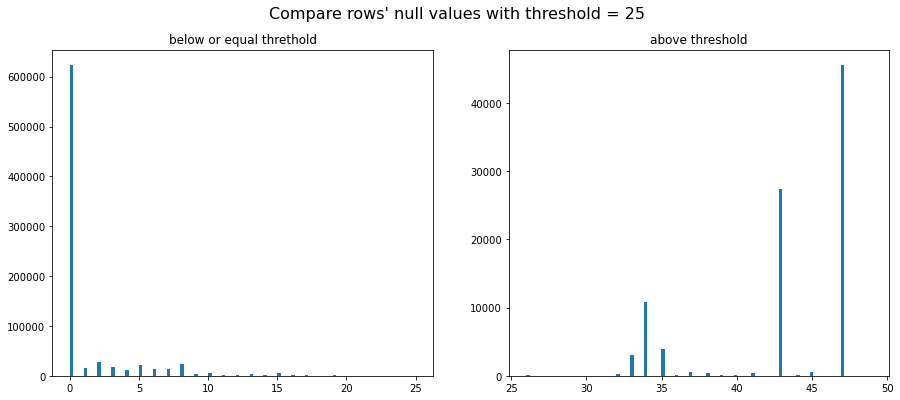

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


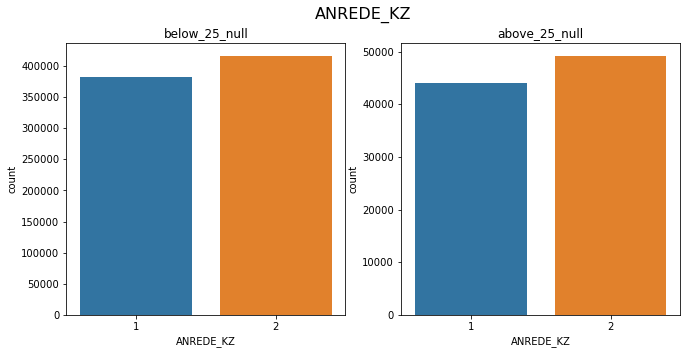

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


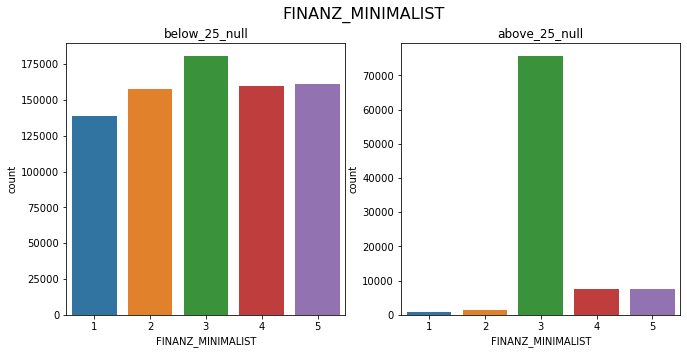

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


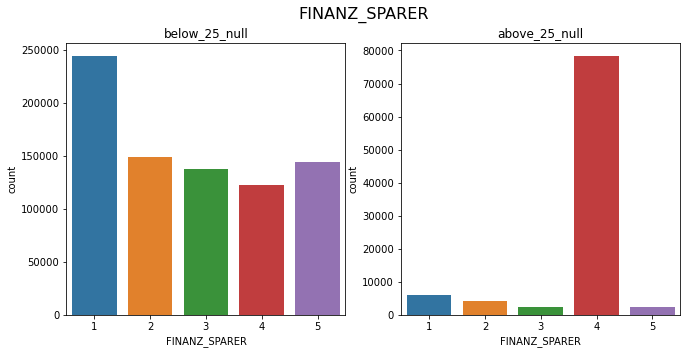

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


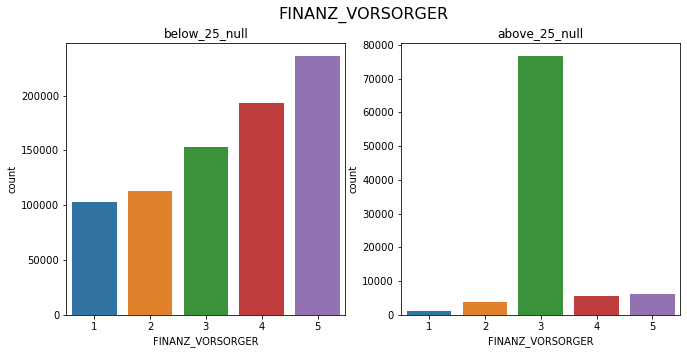

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


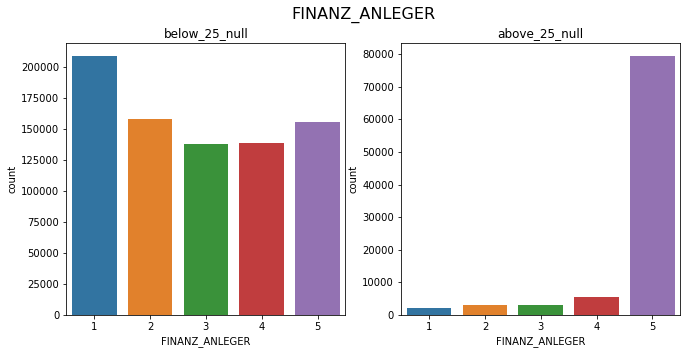

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


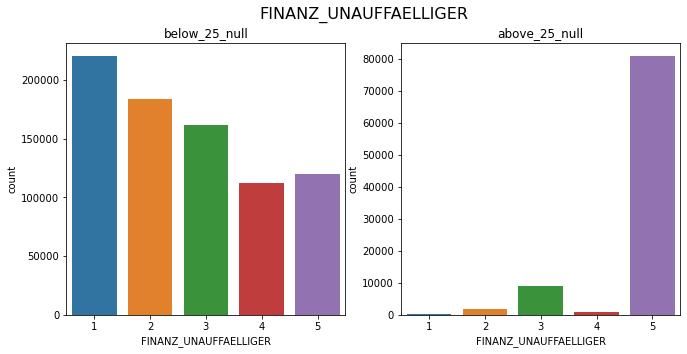

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


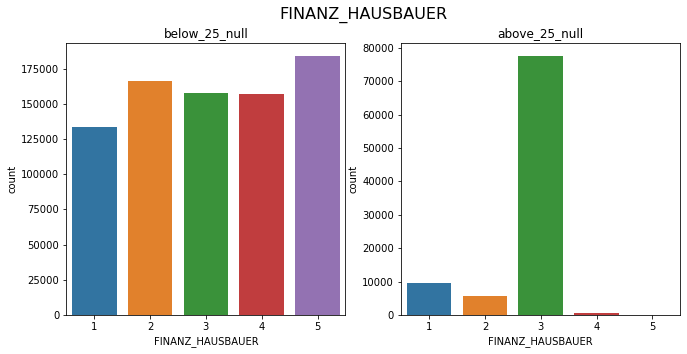

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


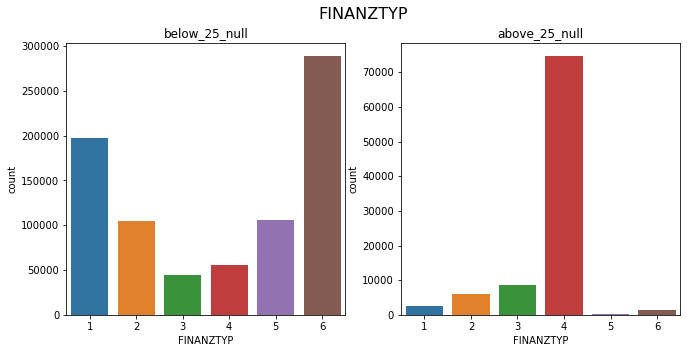

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64
all matched columns: 
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'G

+------------------+--------------------------------------+----------------------------------------------------------------------------+
|   column name    | Num. unique features for categorical |                               unique values                                |
+------------------+--------------------------------------+----------------------------------------------------------------------------+
|    ANREDE_KZ     |                  2                   |                                   [1 2]                                    |
| GREEN_AVANTGARDE |                  2                   |                                   [0 1]                                    |
|     SOHO_KZ      |                  2                   |                               [nan  1.  0.]                                |
|     VERS_TYP     |                  2                   |                               [nan  2.  1.]                                |
|   OST_WEST_KZ    |                  2  

+-----------------------+--------------------------------+----------------------------------------------------------------------------+
|      column name      | Num. unique features for mixed |                               unique values                                |
+-----------------------+--------------------------------+----------------------------------------------------------------------------+
|      ------------     |    ------------------------    |                    ------------------------------------                    |
|  LP_LEBENSPHASE_FEIN  |               40               |  [15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.  |
|                       |                                |    7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.  |
|                       |                                |                             9. 34. 40. 16. 17.]                            |
|  LP_LEBENSPHASE_GROB  |               12      

column name          number of unique features for categorical
------------------------------------------------------------
ANREDE_KZ                               2
CJT_GESAMTTYP                           6
FINANZTYP                               6
GFK_URLAUBERTYP                        12
GREEN_AVANTGARDE                        2
LP_FAMILIE_FEIN                        11
LP_FAMILIE_GROB                         5
LP_STATUS_FEIN                         10
LP_STATUS_GROB                          5
NATIONALITAET_KZ                        3
SHOPPER_TYP                             4
SOHO_KZ                                 2
VERS_TYP                                2
ZABEOTYP                                6
GEBAEUDETYP                             7
OST_WEST_KZ                             2
CAMEO_DEUG_2015                         9

Number of columns related to categorical: 17



 ------------------------------------------------------------
LP_LEBENSPHASE_FEIN: already one of feat_info attri

In [77]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_cleaned = clean_data(azdias, feat_info)

In [183]:
azdias_cleaned.shape

(798071, 63)

In [607]:
assert azdias_cleaned.shape[0] == azdias_manual_clean.shape[0], "clean_data function is not working properly, rows mismatch"
assert azdias_cleaned.shape[1] == azdias_manual_clean.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


In [706]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
imputed_general_data = imp.fit_transform(azdias_cleaned)

In [707]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_general_data = scaler.fit_transform(imputed_general_data)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**Answer:**
- I decided to fill missing data using 'Simple Imputer', and to scale data using 'StandardScaler', and both of them are found in 'sklearn' library
- Missing values are handled using different interpolation techniques which estimate the missing values from the other training examples. 

- We decide which method to use according to calculating 'central tendency' methods of data
- 'Mean' , 'Meadian' and 'Mode' are three methods we can choose from to fill missing data (or even we can decide a value ourselves).

- The 'Mean' is the most frequently used measure of central tendency because it uses all values in the data set to give you an average.
- The 'Median' is better than the mean for skewed distributions because it isn’t influenced by extremely large values.
- The 'Mode' is the only measure you can use for nominal or categorical data that can’t be ordered.

- 'Simple Imputer' by default is using 'Mean', and that we used here to calculate missing data.
- StandardScaler' is used for making data points generalized so that the distance between them will be lower, which makes algorithm works better, also it necessary for biased datasets as it makes all data points in near ranges from each other.

- sources:

- https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
- https://www.scribbr.com/frequently-asked-questions/whats-the-best-measure-of-central-tendency-to-use/#:~:text=The%20mean%20is%20the%20most,influenced%20by%20extremely%20large%20values.
- https://analyticsindiamag.com/why-data-scaling-is-important-in-machine-learning-how-to-effectively-do-it/#:~:text=Scaling%20the%20target%20value%20is,learn%20and%20understand%20the%20problem.&text=Scaling%20of%20the%20data%20comes,algorithms%20in%20the%20data%20set.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [708]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(n_components = azdias_cleaned.shape[1])
pca_general_data = pca.fit_transform(scaled_general_data)

In [709]:
explained_variance_df = pd.DataFrame([pca.explained_variance_ratio_], columns = [azdias_cleaned.columns])
explained_variance_df

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,CAMEO_INTL_2015_tens,CAMEO_INTL_2015_ones
0,0.183778,0.136896,0.083092,0.053687,0.041659,0.034669,0.032288,0.026515,0.023546,0.021134,...,0.002557,0.002277,0.002205,0.002063,0.001908,0.001894,0.001794,0.00136,0.001271,0.000116


Text(0.5, 0, 'Feature Names')

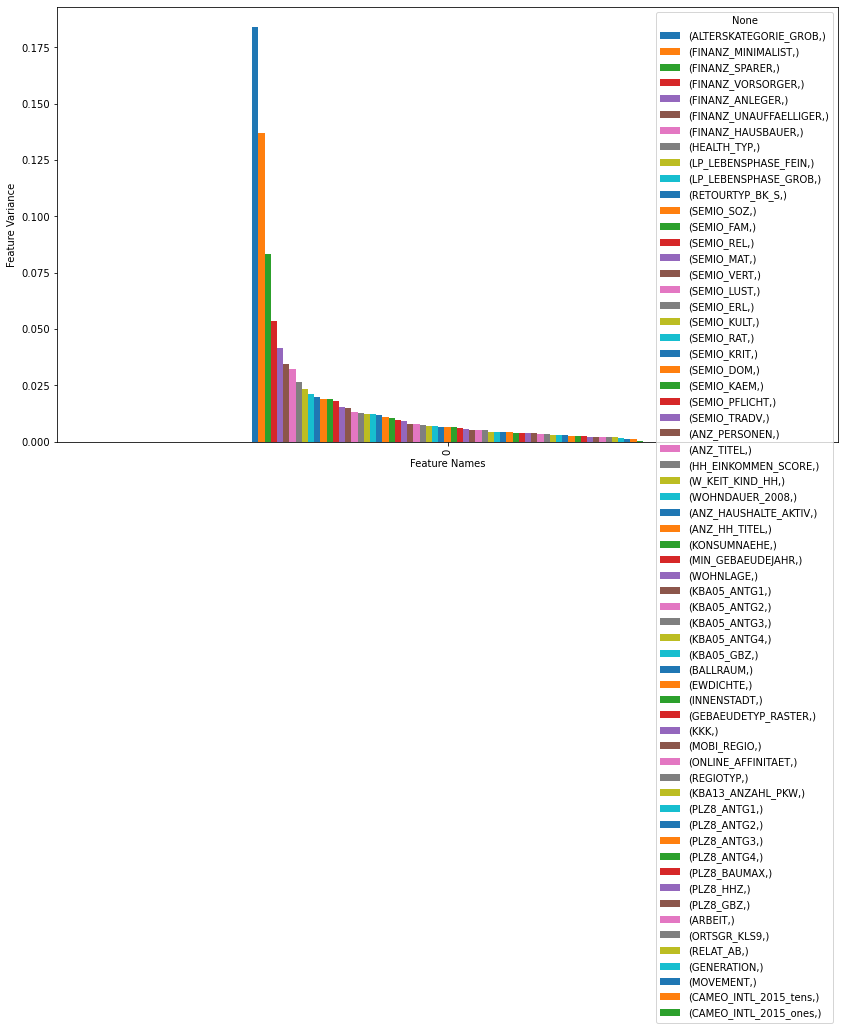

In [710]:
# plot variance accounted for by each principal component.
fig, ax = plt.subplots(figsize = (14,8))

# Plot the feature weights as a function of the components
explained_variance_df.plot(ax = ax, kind = 'bar')
ax.set_ylabel("Feature Variance")
ax.set_xlabel("Feature Names")

In [711]:
# decide what to retain and what to drop
#explained_variance_lst = list(pca.explained_variance_ratio_)
pca_threshold = 0.0060
above_pca_threshold = [x for x in list(pca.explained_variance_ratio_) if x>pca_threshold]
#print(len(above_pca_threshold))

In [715]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = len(above_pca_threshold))
pca_general_data_retained = pca.fit_transform(pca_general_data)

In [716]:
cols = list(azdias_cleaned.columns)[:pca_general_data_retained.shape[1]]
pca_data_general_retained_df = pd.DataFrame(pca_general_data_retained, columns=cols)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Answer:**
- using threshold for variance equals (0.0060), I get 34 features above this threshold, which I preserved for next step, I preferred not to increase my threshold value than that to make the number of remained feature about half that of the real data which was 63.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [717]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def weight_col(df, component_number):
    component_num = component_number-1
    weights = pca.components_
    cols = [df.columns]
    weight_col = pd.DataFrame(weights.T, columns = cols)
    
    pca_component = pd.DataFrame(df.iloc[component_num])
    pca_component.sort_values(component_num, ascending=False, inplace=True)
    print(pca_component.sort_values(component_num, ascending=False))
    pos_values = [x for x in pca_component[component_num] if x>0]
    neg_values = [x for x in pca_component[component_num] if x<0]
    print(f"\n\nNumber of Positive values in component_number {component_number} is {len(pos_values)}")
    print(f"\n\nNumber of Negative values in component_number {component_number} is {len(neg_values)}")
    return pca_component

In [718]:
def pca_most_correlated_features(df, pca, component_no, num_features):
    '''
    Create a DataFrame of the PCA results
    Visualizes the PCA results for a speacific component number for a speacific number of features
    '''

    pca_comp = pd.concat([df.head(num_features), df.tail(num_features)])
    #c = ['red', 'yellow', 'black', 'blue', 'orange']
    pca_comp.plot(kind='bar', 
                  title=f'Most {num_features*2} weighted features for PCA component {component_no}', 
                  figsize=(12, 6))
    
    plt.show()
    
    return pca_comp

In [719]:
pca_component_1_df = weight_col(pca_data_general_retained_df, 1)

                              0
FINANZ_UNAUFFAELLIGER  3.565922
ALTERSKATEGORIE_GROB   3.183487
SEMIO_TRADV            1.100208
FINANZ_HAUSBAUER       1.082341
SEMIO_LUST             1.009450
LP_LEBENSPHASE_FEIN    0.665209
LP_LEBENSPHASE_GROB    0.656231
KONSUMNAEHE            0.519079
MIN_GEBAEUDEJAHR       0.263643
SEMIO_VERT             0.205635
SEMIO_KAEM             0.062233
ANZ_HH_TITEL          -0.000287
SEMIO_MAT             -0.012950
ANZ_TITEL             -0.090133
SEMIO_PFLICHT         -0.115249
W_KEIT_KIND_HH        -0.117531
SEMIO_SOZ             -0.165419
SEMIO_DOM             -0.179121
FINANZ_ANLEGER        -0.218785
HH_EINKOMMEN_SCORE    -0.238337
ANZ_PERSONEN          -0.247132
RETOURTYP_BK_S        -0.295479
HEALTH_TYP            -0.359075
FINANZ_VORSORGER      -0.448153
WOHNDAUER_2008        -0.605768
SEMIO_ERL             -0.706673
SEMIO_RAT             -0.746907
SEMIO_KRIT            -0.931967
ANZ_HAUSHALTE_AKTIV   -1.097126
SEMIO_KULT            -1.862153
SEMIO_RE

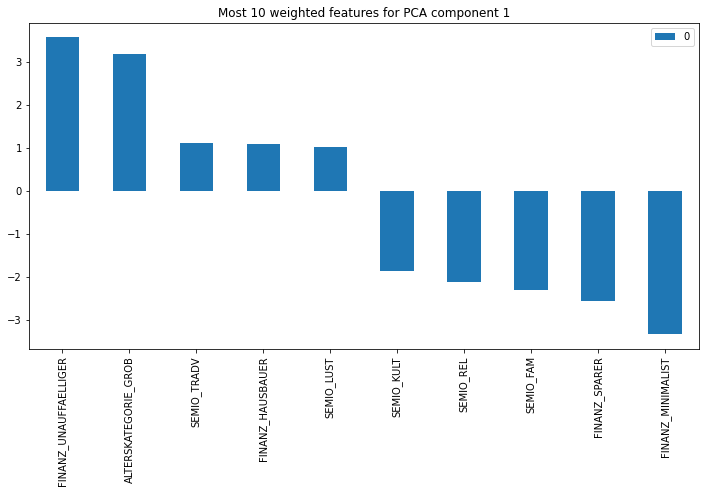

,0
FINANZ_UNAUFFAELLIGER,3.565922
ALTERSKATEGORIE_GROB,3.183487
SEMIO_TRADV,1.100208
FINANZ_HAUSBAUER,1.082341
SEMIO_LUST,1.009450
SEMIO_KULT,-1.862153
SEMIO_REL,-2.120390
SEMIO_FAM,-2.314665
FINANZ_SPARER,-2.565522
FINANZ_MINIMALIST,-3.330260


In [720]:
pca_most_correlated_features(pca_component_1_df, pca, 1, 5)

In [721]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_component_2_df = weight_col(pca_data_general_retained_df, 2)

                              1
LP_LEBENSPHASE_GROB    1.918828
SEMIO_REL              1.644800
SEMIO_VERT             1.185849
HH_EINKOMMEN_SCORE     1.135803
ANZ_TITEL              0.968625
SEMIO_DOM              0.603016
W_KEIT_KIND_HH         0.528594
SEMIO_RAT              0.363499
FINANZ_VORSORGER       0.342983
FINANZ_MINIMALIST      0.204157
WOHNDAUER_2008         0.184899
SEMIO_MAT              0.097807
FINANZ_HAUSBAUER       0.031142
SEMIO_KULT             0.009638
MIN_GEBAEUDEJAHR      -0.147322
SEMIO_KAEM            -0.191059
KONSUMNAEHE           -0.207319
SEMIO_KRIT            -0.219224
ANZ_HAUSHALTE_AKTIV   -0.232069
SEMIO_SOZ             -0.252964
SEMIO_PFLICHT         -0.285106
ANZ_PERSONEN          -0.349434
ALTERSKATEGORIE_GROB  -0.392357
SEMIO_ERL             -0.457285
HEALTH_TYP            -0.504622
LP_LEBENSPHASE_FEIN   -0.645648
ANZ_HH_TITEL          -0.678744
SEMIO_LUST            -0.710605
FINANZ_UNAUFFAELLIGER -0.778132
RETOURTYP_BK_S        -1.021881
SEMIO_TR

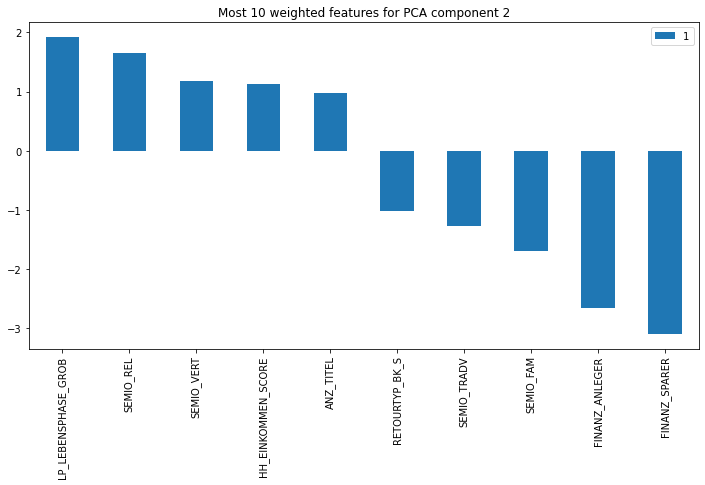

,1
LP_LEBENSPHASE_GROB,1.918828
SEMIO_REL,1.644800
SEMIO_VERT,1.185849
HH_EINKOMMEN_SCORE,1.135803
ANZ_TITEL,0.968625
RETOURTYP_BK_S,-1.021881
SEMIO_TRADV,-1.270074
SEMIO_FAM,-1.691647
FINANZ_ANLEGER,-2.658776
FINANZ_SPARER,-3.088781


In [722]:
pca_most_correlated_features(pca_component_2_df, pca, 2, 5)

In [723]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_component_3_df = weight_col(pca_data_general_retained_df, 3)

                              2
MIN_GEBAEUDEJAHR       1.787458
FINANZ_MINIMALIST      1.559045
SEMIO_MAT              0.950919
RETOURTYP_BK_S         0.742493
FINANZ_HAUSBAUER       0.718521
SEMIO_KULT             0.682940
SEMIO_TRADV            0.569427
ANZ_TITEL              0.476058
SEMIO_DOM              0.396245
SEMIO_KAEM             0.253325
SEMIO_ERL              0.222103
HEALTH_TYP             0.195228
SEMIO_FAM              0.136248
SEMIO_LUST             0.133796
SEMIO_VERT             0.055000
SEMIO_SOZ             -0.008870
FINANZ_ANLEGER        -0.058322
ANZ_HAUSHALTE_AKTIV   -0.096743
WOHNDAUER_2008        -0.166200
KONSUMNAEHE           -0.258201
HH_EINKOMMEN_SCORE    -0.340957
SEMIO_REL             -0.353232
FINANZ_SPARER         -0.434669
ANZ_PERSONEN          -0.538825
SEMIO_PFLICHT         -0.539259
SEMIO_RAT             -0.683479
FINANZ_UNAUFFAELLIGER -0.721562
ANZ_HH_TITEL          -0.873736
W_KEIT_KIND_HH        -0.951736
LP_LEBENSPHASE_FEIN   -0.971672
LP_LEBEN

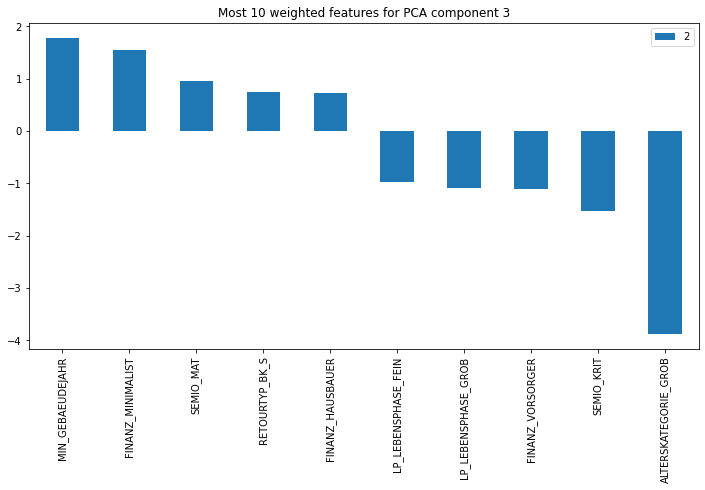

,2
MIN_GEBAEUDEJAHR,1.787458
FINANZ_MINIMALIST,1.559045
SEMIO_MAT,0.950919
RETOURTYP_BK_S,0.742493
FINANZ_HAUSBAUER,0.718521
LP_LEBENSPHASE_FEIN,-0.971672
LP_LEBENSPHASE_GROB,-1.097730
FINANZ_VORSORGER,-1.115146
SEMIO_KRIT,-1.528803
ALTERSKATEGORIE_GROB,-3.884932


In [724]:
pca_most_correlated_features(pca_component_3_df, pca, 3, 5)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Answer:**
- Positive values means that the features are directly proportion to Principal Component.
- Negative values means that there's no specific characteristic in that features related to Principal Component.
- Poth +ve and -ve weighted features are important to Principal Component.


- 1st Component
    - According to: 'FINANZ_UNAUFFAELLIGER' and 'ALTERSKATEGORIE_GROB', Financial typology affects by Estimated age based on given name analysis.
    - According to: 'SEMIO_TRADV', 'FINANZ_HAUSBAUER' and 'SEMIO_LUST', Personality typology increases by increasing Financial typology.
    - Also most highest -ve weights for: 'SEMIO_KULT', 'SEMIO_REL', 'SEMIO_FAM', 'FINANZ_SPARER' and 'FINANZ_MINIMALIST', it states that  Personality typology decreasing related to Financial typology decreasing.
 

- 2nd Component:
    - According to: 'LP_LEBENSPHASE_GROB', 'SEMIO_REL', 'SEMIO_VERT', 'HH_EINKOMMEN_SCORE', 'ANZ_TITEL', Life stage affects Estimated household net income, which impact the Number of professional academic title holders in household and affects on Personality typology for each person.
    - According to: 'RETOURTYP_BK_S', 'SEMIO_TRADV', 'SEMIO_FAM', 'FINANZ_ANLEGER', 'FINANZ_SPARER', Financial typology decreasing causes Personality typology decreasing.
    

- 3rd Component:
    - According to: 'MIN_GEBAEUDEJAHR', 'FINANZ_MINIMALIST', 'SEMIO_MAT', 'RETOURTYP_BK_S', 'FINANZ_HAUSBAUER', Financial typology increase building in the city which directly affects Personality typology for each citizen.
    - According to: 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'FINANZ_VORSORGER', 'SEMIO_KRIT', 'ALTERSKATEGORIE_GROB',  Estimated age based on given name analysis affects directly Life stage,  Life stage decreases according to Financial typology decreasing which impact the Personality typology per each citizen. 


- In the 3 Components, it's obvious that each component weights are distributing people into two main categories, which are poor and rich.

- I noteced that by getting higher component number, positive values number increases, while negative values number decreases.   

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [627]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans    # MiniBatchKMeans

#pca_data_retained_df
def Kmeans_clustering(df, cluster_num):
    Kmeans = KMeans(n_clusters=cluster_num)
    
    # run k-means clustering on the data and...
    model_i = Kmeans.fit(df)   
    
    labels = model_i.predict(df)
    # compute the average within-cluster distances.
    score = model_i.score(df)
    #score = abs(score) 
    centroid = model_i.cluster_centers_
    return Kmeans, score, labels, centroid

In [628]:
def plot_clusters(centers, scores):
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');

In [240]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


def cluster_range(df, n1, n2):
    centroids_num = [i for i in range(n1, n2)]
    kmeans = []
    scores = []
    predictions = []
    centers = []
    

    for i in centroids_num:
        model, score, predict, centroid = Kmeans_clustering(df, i)
        kmeans.append(model)
        scores.append(abs(score))
        predictions.append(predict)
        centers.append(centroid)
        print(f"Clustering with {i} clusters finished.")


    return kmeans, scores, predictions, centers, centroids_num

In [241]:
kmeans_general, scores_general, predictions_general, centers_general, centroids_num_general = cluster_range(pca_data_general_retained_df, 1, 21)

Clustering with 1 clusters finished.
Clustering with 2 clusters finished.
Clustering with 3 clusters finished.
Clustering with 4 clusters finished.
Clustering with 5 clusters finished.
Clustering with 6 clusters finished.
Clustering with 7 clusters finished.
Clustering with 8 clusters finished.
Clustering with 9 clusters finished.
Clustering with 10 clusters finished.
Clustering with 11 clusters finished.
Clustering with 12 clusters finished.
Clustering with 13 clusters finished.
Clustering with 14 clusters finished.
Clustering with 15 clusters finished.
Clustering with 16 clusters finished.
Clustering with 17 clusters finished.
Clustering with 18 clusters finished.
Clustering with 19 clusters finished.
Clustering with 20 clusters finished.
----------------------------------------------------------------------------------------------------
Predictions:
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 1, ..., 1, 0, 1]), array([0, 1, 1, ..., 0, 0, 2]), array([2, 1, 0, ..., 1, 2, 3]), array(

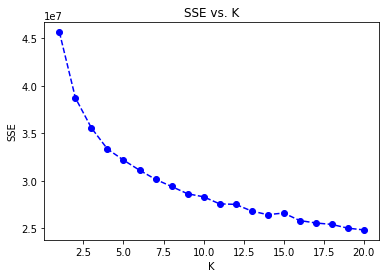

In [242]:
# Plot the score against k
plot_clusters(centroids_num_general, scores_general)

In [243]:
# Plot the score against predictions
from mpl_toolkits.mplot3d import Axes3D




def plotData_3D(df_before_clustering, centroids, labels, title_, name1, name2):
    
    #axes = Axes3D(fig)
    
    fig = plt.figure(figsize=(11, 5))
    fig.suptitle(title_, fontsize=16)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(df_before_clustering.iloc[:, 0], df_before_clustering.iloc[:, 1], alpha=0.5)
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(df_before_clustering.iloc[:, 0], df_before_clustering.iloc[:, 1], c=labels, alpha=0.5,  cmap='tab10')
    ax2.scatter(centroids[:, 0], centroids[:,1], marker="*", s=100, c='r')
    
    ax1.set_title(name1)
    ax2.set_title(name2)
    plt.show()

In [629]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# using number of clusters = 20
kmeans_general_20 = kmeans_general[19] 
centers_general_20 = centers_general[19]
predictions_general_20= predictions_general[19]
score_general_20 = scores_general[19]
# Kmeans_clustering(pca_data_general_retained_df, 20)

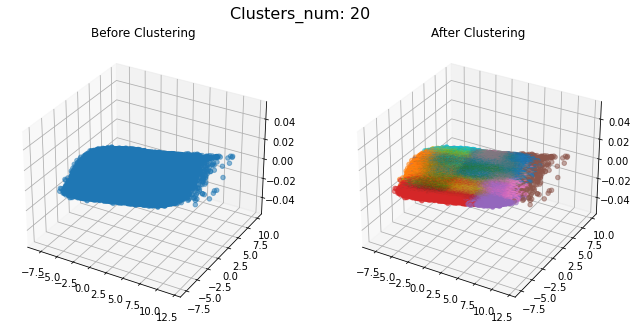

In [245]:
plotData_3D(pca_data_general_retained_df, centers_general_20, predictions_general_20, f'Clusters_num: {len(centers_general_20)}', 'Before Clustering', 'After Clustering')

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Answer:**
- I uesd clusters' numbers from 1 to 20, I noticed that the lowest score was with number_of_clusters=29 so I used it to segment population.
- In the plot above, the ekbow is when number of clusters = 14 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [727]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [728]:
customers.shape

(191652, 85)

Column Name                    Number of missing cells
--------------------------------------------------


Number of columns that has null values > 200000: 0


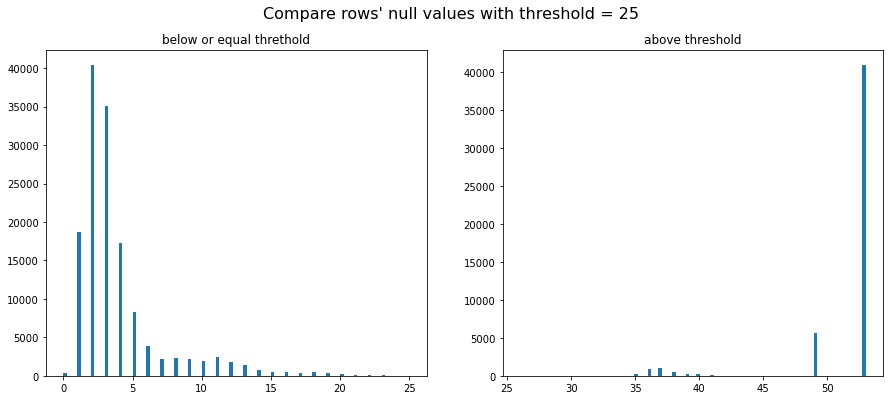

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


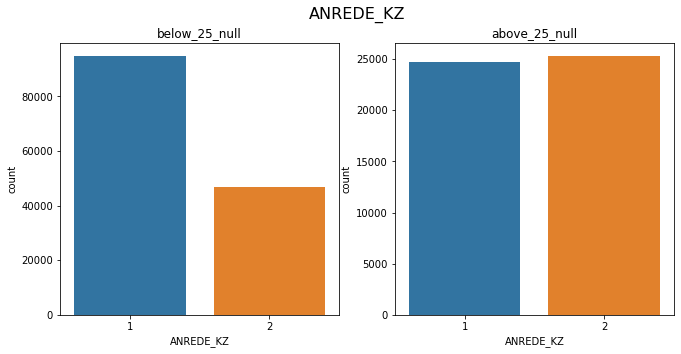

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


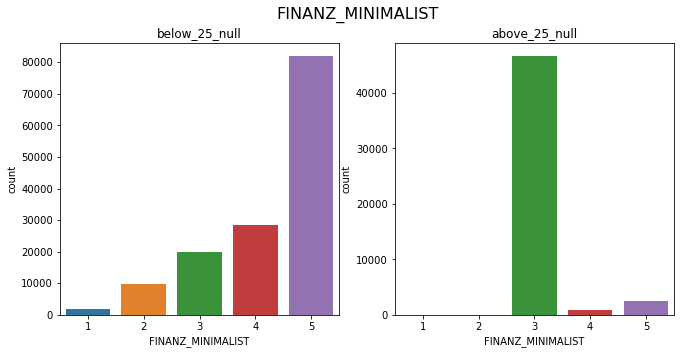

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


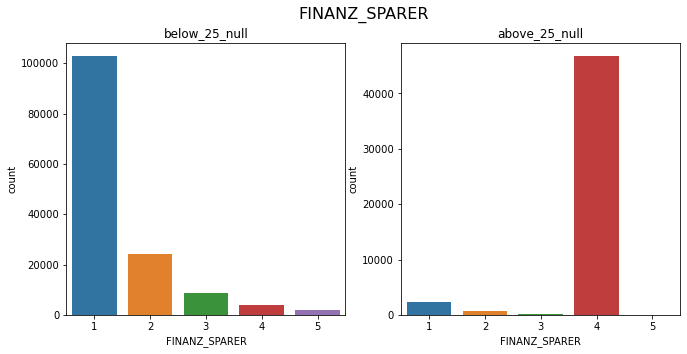

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


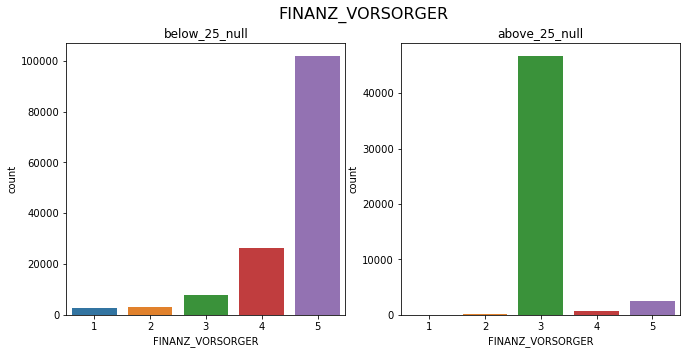

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


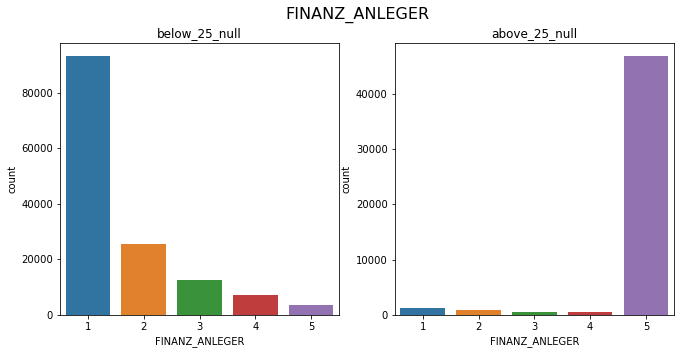

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


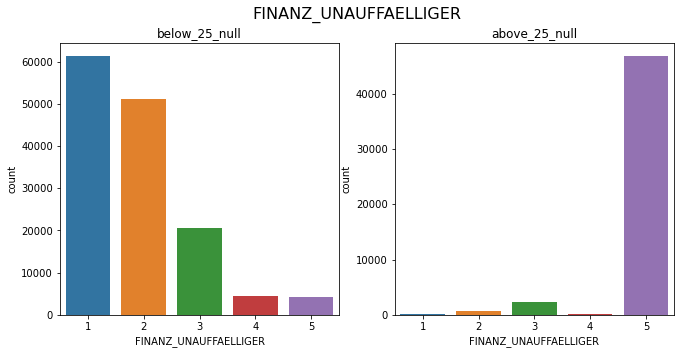

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


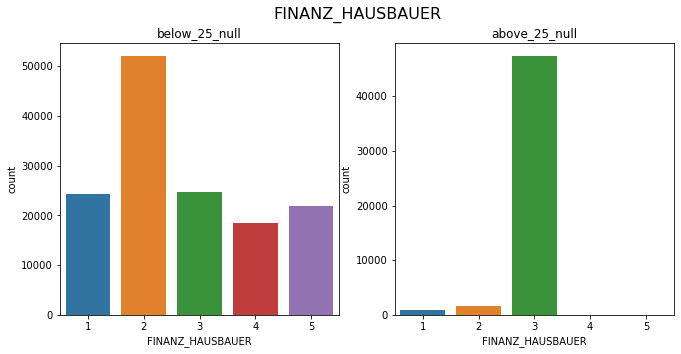

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


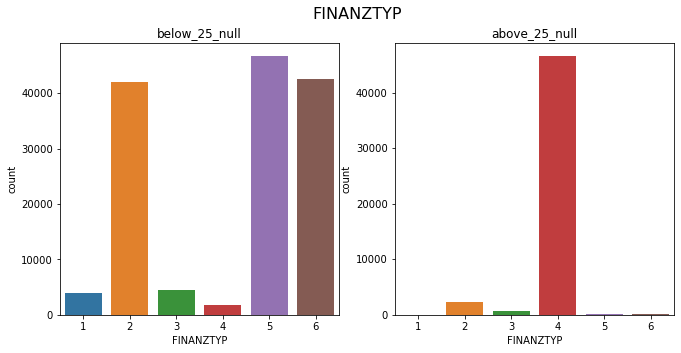

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64
all matched columns: 
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'G

+------------------+--------------------------------------+----------------------------------------------------------------------------+
|   column name    | Num. unique features for categorical |                               unique values                                |
+------------------+--------------------------------------+----------------------------------------------------------------------------+
|    ANREDE_KZ     |                  2                   |                                   [1 2]                                    |
| GREEN_AVANTGARDE |                  2                   |                                   [1 0]                                    |
|     SOHO_KZ      |                  2                   |                               [ 0. nan  1.]                                |
|     VERS_TYP     |                  2                   |                               [ 1.  2. nan]                                |
|   OST_WEST_KZ    |                  2  

+-----------------------+--------------------------------+----------------------------------------------------------------------------+
|      column name      | Num. unique features for mixed |                               unique values                                |
+-----------------------+--------------------------------+----------------------------------------------------------------------------+
|      ------------     |    ------------------------    |                    ------------------------------------                    |
|  LP_LEBENSPHASE_FEIN  |               40               |  [20. nan 13. 31. 17.  6. 28.  5. 27. 40. 35.  2. 19. 38. 36.  8. 34. 10.  |
|                       |                                |   12. 26. 11.  9. 37. 14. 39. 32.  7. 15. 23. 21. 25. 33. 16. 24. 30. 18.  |
|                       |                                |                             4. 22.  1. 29.  3.]                            |
|  LP_LEBENSPHASE_GROB  |               12      

LP_STATUS_GROB                          5
NATIONALITAET_KZ                        3
SHOPPER_TYP                             4
SOHO_KZ                                 2
TITEL_KZ                                4
VERS_TYP                                2
ZABEOTYP                                6
KK_KUNDENTYP                            6
GEBAEUDETYP                             6
OST_WEST_KZ                             2
CAMEO_DEUG_2015                         9

Number of columns related to categorical: 20



 ------------------------------------------------------------
LP_LEBENSPHASE_FEIN: already one of feat_info attributes
LP_LEBENSPHASE_GROB: already one of feat_info attributes
PRAEGENDE_JUGENDJAHRE: already one of feat_info attributes
WOHNLAGE: already one of feat_info attributes
CAMEO_INTL_2015: already one of feat_info attributes
KBA05_BAUMAX: already one of feat_info attributes
PLZ8_BAUMAX: already one of feat_info attributes
+----------------------+--------------------------------

In [729]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers, feat_info)

In [649]:
customers_cleaned.shape

(141721, 66)

In [652]:
diff_cols = [x for x in customers_cleaned.columns if x not in azdias.columns]
diff_cols

['GEBURTSJAHR', 'ALTER_HH', 'KBA05_BAUMAX']

In [730]:
customers_cleaned.isnull().sum().sum()

250976

In [731]:
for i in diff_cols:
    print(f'{i}: {customers_cleaned[i].nunique()}')

GEBURTSJAHR: 112
ALTER_HH: 20
KBA05_BAUMAX: 5


In [732]:
# drop diferent features to be able to use the fitted models for azdias dataset with customers dataset
customers_cleaned.drop(diff_cols, axis=1, inplace=True)

In [733]:
customers_cleaned.shape

(141721, 63)

In [526]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

In [738]:
customers_imputer = imp.transform(customers_cleaned)
customers_normalize = scaler.transform(customers_imputer)
customers_pca = pca.transform(customers_normalize)
customer_clusters = kmeans_general_20.predict(customers_pca)     # kmeans_general_20

D:\Programs\Anaconda2\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


In [739]:
customers_pca.shape

(141721, 34)

In [599]:
pca_data_customer_retained_df

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,HEALTH_TYP,LP_LEBENSPHASE_FEIN,...,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008
0,-2.999911,-3.076602,1.564577,1.586627,-1.465654,2.864717,-1.795578,1.286584,-1.109801,-0.423599,...,1.189154,-0.299354,0.001535,1.448238,0.370497,0.636066,0.194419,0.466187,-0.773302,-0.663404
1,3.695249,-2.151699,-2.464650,-1.550846,-0.846942,-1.477510,-0.940338,0.294872,-0.933632,2.253045,...,-0.581057,0.811154,0.386161,0.714742,-0.045780,0.431298,0.685730,0.692151,0.838264,0.032859
2,-2.680556,-1.401832,-0.368100,3.848852,-0.466002,-0.269408,0.746851,-0.111949,0.237067,1.065697,...,-0.099757,-0.664563,-0.579079,-1.268825,-0.386494,0.380447,-0.120916,-1.254331,0.450000,-0.526712
3,1.876472,4.996144,1.209554,0.768283,2.454552,-0.073311,-0.021459,-1.894081,-1.641068,-0.413048,...,-1.247126,0.272799,0.901251,0.521693,-1.454058,-0.326098,-0.924114,0.798648,-0.125518,-0.071006
4,0.398268,-0.754040,1.591840,-0.651973,-2.081602,1.321904,-0.659135,-2.099679,0.300717,0.485251,...,-0.274437,0.353585,0.444933,-0.030975,0.044166,0.278366,0.141318,-0.203554,0.645775,0.111559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141716,1.191327,-0.892378,3.125606,-2.694242,-4.190822,0.001265,0.251129,-0.873905,-0.196714,0.060431,...,-0.597774,-0.540070,-0.235730,0.162425,-0.651672,0.260898,-0.025540,0.226116,0.369324,-0.993252
141717,-0.436197,-0.904380,-4.102903,0.931694,0.034068,1.550359,-1.058591,-0.525136,-0.612205,1.057620,...,-0.185540,-0.200575,-1.360497,-0.954450,-0.697913,-0.609679,0.918292,-0.090651,0.234807,0.902487
141718,-1.646381,-2.504727,-0.256979,-1.776392,1.875571,0.571356,-1.187033,-1.348418,1.216551,0.646847,...,-0.081262,-0.231987,-0.404639,-0.546953,0.695163,0.033638,0.662224,0.545531,1.133626,0.221792
141719,2.016573,0.471939,-2.930736,-1.237500,1.008699,-1.269485,2.369797,-0.135372,0.005127,-1.062595,...,-0.881962,-1.220089,1.016102,-0.374682,0.181013,-0.524880,0.560766,0.649029,0.882618,-0.679408


In [168]:
kmeans_customer, scores_customer, predictions_customer, centers_customer, centroids_num_customer = cluster_range(pca_data_customer_retained_df, 1, 21)

Clustering with 1 clusters finished.
Clustering with 2 clusters finished.
Clustering with 3 clusters finished.
Clustering with 4 clusters finished.
Clustering with 5 clusters finished.
Clustering with 6 clusters finished.
Clustering with 7 clusters finished.
Clustering with 8 clusters finished.
Clustering with 9 clusters finished.
Clustering with 10 clusters finished.
Clustering with 11 clusters finished.
Clustering with 12 clusters finished.
Clustering with 13 clusters finished.
Clustering with 14 clusters finished.
Clustering with 15 clusters finished.
Clustering with 16 clusters finished.
Clustering with 17 clusters finished.
Clustering with 18 clusters finished.
Clustering with 19 clusters finished.
Clustering with 20 clusters finished.
----------------------------------------------------------------------------------------------------
Predictions:
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 1, 0]), array([1, 0, 1, ..., 1, 0, 1]), array([0, 1, 0, ..., 0, 1, 0]), array(

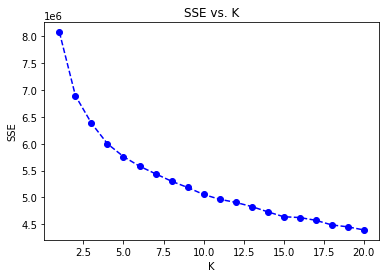

In [169]:
plot_clusters(centroids_num_customer, scores_customer)

In [170]:
# get kmeans for customers data with number of clusters = 20
kmeans_customer_20 = kmeans_customer[19]
predictions_customer_20 = predictions_customer[19]
centers_customer_20 = centers_customer[19]
scores_customer_20 = scores_customer[19]

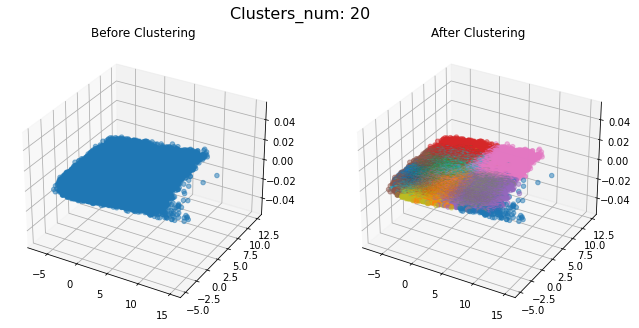

In [172]:
plotData_3D(pca_data_customer_retained_df, centers_customer_20, predictions_customer_20, f'Clusters_num: {len(centers_customer_20)}', 'Before Clustering', 'After Clustering')

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [743]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def CountPlot_(df1, df2, title, name1, name2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 9))
    fig.suptitle(title, fontsize=16)

    sns.countplot(df1, ax = axes[0])
    sns.countplot(df2, ax = axes[1])


    axes[0].set_title(name1)
    axes[1].set_title(name2)
    plt.show()

D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Programs\Anaconda2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


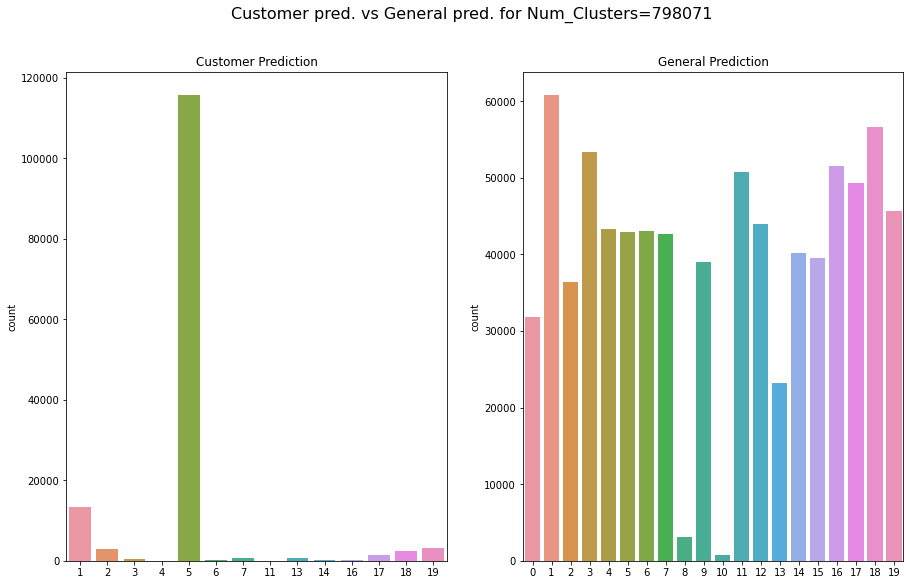

In [747]:
CountPlot_(customer_clusters, predictions_general_20, f'Customer pred. vs General pred. for Num_Clusters={len(predictions_general_20)}', 'Customer Prediction', 'General Prediction')

In [ ]:
#score_customer, predict_customer, centroid_customer = Kmeans_clustering(pca_data_customer_retained_df, 29)

In [173]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroids_10 = scaler_customer.inverse_transform(pca_customer.inverse_transform(kmeans_customer_20.cluster_centers_))

In [216]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_cols = list(pca_data_customer_retained_df.columns)[:len(centroids_10)]
#len(underrepresented_cols)
underrepresented_customer_df = pd.DataFrame(centroids_10, underrepresented_cols)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)



**Answer:**
- Cluster 5 seems to be overrepresented in the customers data compared to general population data.
- all otherclusters seems to be underrepresented in the customers data compared to general population data.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.